# Rotterdam stylized case
#### last updated 17/3/2020

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
#import pickle
import csv

from collections import OrderedDict

# You can skip this part and read it directly from the csv file

### Step 1A: calculate one possible realisation of actual storm surge levels at Rotterdam, for 4 different scenarios of SLR 
Each time you run you get another possible realisation of storm surge levels

Text(0, 0.5, 'Storm surge height (m)')

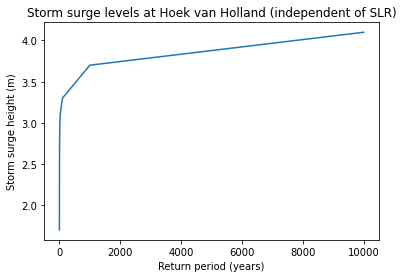

In [3]:
#STORM SURGE LEVELS AT HOEK VAN HOLLAND (ASSUMED TO BE INDEPENDENT OF SEA LEVEL RISE)
#Very roughly taken from Sterl et al. (2009)
RP = [1/5,  1/2,1 ,  2,  5,10,25  ,100,1000,10000]
surge = [1.7,2  ,2.2 ,2.4,2.7,2.9,3.1,3.3,3.7 ,4.1]
plt.plot(RP,surge)
plt.title('Storm surge levels at Hoek van Holland (independent of SLR)')
plt.xlabel('Return period (years)')
plt.ylabel('Storm surge height (m)')

In [4]:
#FOR NOW: ASSUME THAT ONE STORM PER YEAR WILL OCCUR
startyear = 2021
endyear = 2120
#APPROXIMATION OF THE GUMBEL PLOT OF Sterl et al. (2009) 
#"An ensemble study of extreme storm surge related water levels in the North Sea in a changing climate"
mu = 2.33
beta = 0.234
surges_t = np.random.gumbel(mu,beta,size=100) #calculates a storm surge level (m) for each year

In [5]:
#SLR scenarios
year = [2000,2020,2050,2075,2100]
A =    [0,   0.1 , 0.2, 0.3, 0.4] #Haasnoot et al. 2020, lower part of blue shaded area
B =    [0,   0.1 ,0.25,0.45, 1.0] #Middle of RCP4.5
C =    [0,   0.1 , 0.3,0.7 , 1.8] #Middle of RCP8.5
D =    [0,   0.15, 0.4, 1.0 ,3.0] #Max of RCP8.5   

#determine coefficients of paraboles plotted through these functions
A_p = np.polyfit(year,A,2) #returns the coefficient of the paraboles (highest first)
B_p = np.polyfit(year,B,2)
C_p = np.polyfit(year,C,2)
D_p = np.polyfit(year,D,2)

time = np.arange(2021,2121) #create list from 2021 to 2120

#CREATE TIME SERIES FOR SEA LEVEL RISE (IMITATE THOSE IN HAASNOOT ET AL 2020)
A_t = [(lambda x: A_p[2]+A_p[1]*x+A_p[0]*x**2)(x) for x in time]
B_t = [(lambda x: B_p[2]+B_p[1]*x+B_p[0]*x**2)(x) for x in time]
C_t = [(lambda x: C_p[2]+C_p[1]*x+C_p[0]*x**2)(x) for x in time]
D_t = [(lambda x: D_p[2]+D_p[1]*x+D_p[0]*x**2)(x) for x in time]

In [6]:
#Sum the storm surge levels and the SLR scenarios
levels_A_t = surges_t+A_t
levels_B_t = surges_t+B_t
levels_C_t = surges_t+C_t
levels_D_t = surges_t+D_t

#CALCULATE THE RPS (what would be the return period of the future floods for statistics of the current situation)
#WILL PROBABLY NO LONGER BE USED IN THE MODEL, BUT NICE TO KEEP FOR NOW
RPs_A_t = np.interp(levels_A_t,surge,RP)
RPs_B_t = np.interp(levels_B_t,surge,RP)
RPs_C_t = np.interp(levels_C_t,surge,RP)
RPs_D_t = np.interp(levels_D_t,surge,RP)

Text(0.5, 1.0, 'Scenario D')

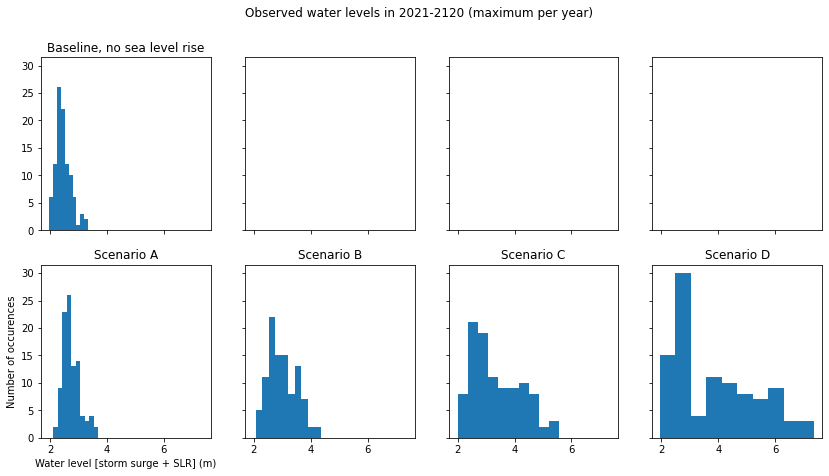

In [7]:
### PLOT THE HISTOGRAMS OF THE DIFFERENT RETURN PERIODS
figure, axes = plt.subplots(nrows=2,ncols=4,sharey=True,sharex=True,figsize=(14,7))
axes[0,0].hist(surges_t)
axes[1,0].hist(levels_A_t)
axes[1,1].hist(levels_B_t)
axes[1,2].hist(levels_C_t)
axes[1,3].hist(levels_D_t)
figure.suptitle('Observed water levels in 2021-2120 (maximum per year)')
axes[0,0].set_title('Baseline, no sea level rise')
axes[1,0].set_xlabel('Water level [storm surge + SLR] (m)')
axes[1,0].set_ylabel('Number of occurences')
axes[1,0].set_title('Scenario A')
axes[1,1].set_title('Scenario B')
axes[1,2].set_title('Scenario C')
axes[1,3].set_title('Scenario D')

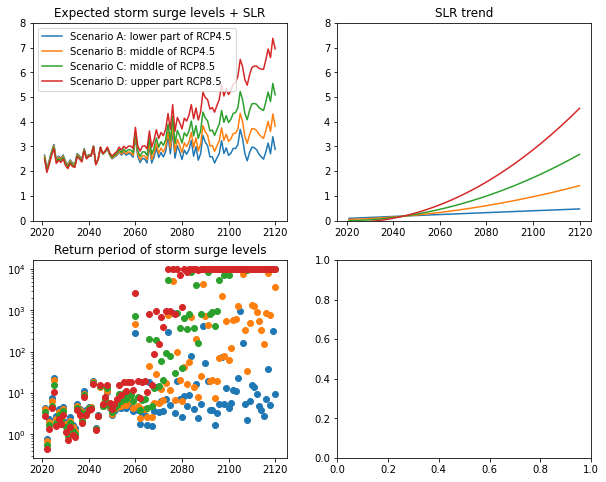

In [8]:
#Plot as a time series

fig, axes = plt.subplots(nrows=2,ncols=2,sharey=False,figsize=(10,8))
#fig = plt.figure()
axes[0,0].plot(time,levels_A_t,
             time,levels_B_t,
             time,levels_C_t,
             time,levels_D_t)
axes[0,0].legend(labels=[
    'Scenario A: lower part of RCP4.5',
    'Scenario B: middle of RCP4.5',   
    'Scenario C: middle of RCP8.5',   
    'Scenario D: upper part RCP8.5',
])
axes[0,0].set_title('Expected storm surge levels + SLR')
axes[0,1].set_title('SLR trend')
axes[1,0].set_title('Return period of storm surge levels')
axes[0,1].plot(time,A_t,time,B_t,time,C_t,time,D_t)

axes[0,0].set_ylim(0,8)
axes[0,1].set_ylim(0,8)

axes[1,0].scatter(time,RPs_A_t)
axes[1,0].scatter(time,RPs_B_t)
axes[1,0].scatter(time,RPs_C_t)
axes[1,0].scatter(time,RPs_D_t)
axes[1,0].set_yscale('log')

In [79]:
# Save the above series to the folder SurgeSeries so we can quickly reload
#SurgeSeries(None,None,levels_D_t,time).to_csv('D.csv')

### Step 1B: Start here if you want to load existing series

In [2]:
allSurgeSeries = []

class SurgeSeries:
    "Common class for all storm surge series"
    def __init__(self,name=None,description=None,surgelevel=None,years=np.arange(2021,2121)):
        self.name = name
        self.description = description
        self.surgelevel = surgelevel
        self.years = years
        allSurgeSeries.append(self) #Add to the overview of all flood protection objects
        
    def to_csv(self,filename):
        "Write to a csv file (weakness: does not save the metadata yet)"
        zipped = list(zip(self.years,self.surgelevel)) #zip the two lists
        with open(os.path.join("SurgeSeries",filename), "w",newline='') as f:
            writer = csv.writer(f)
            for row in zipped:
                writer.writerow(row)
    
    def from_csv(self,filename):
        filename = os.path.join("SurgeSeries",filename)
        years = []
        surgelevel = []
        with open(filename) as f:
            reader = csv.reader(f)
            for row in reader:
                years.append(row[0])
                surgelevel.append(row[1])
        self.years = [int(i) for i in years]
        self.surgelevel = [float(i) for i in surgelevel] #convert strings to floats
        
    def __repr__(self): #this is wat you see if you say "object" (without printing)
        return self.name + " " + self.description + "\n" + str(list(zip(self.years,self.surgelevel)))
        
    def __str__(self): #this is what you see if you say "print(object)"
        return self.name + " " + self.description + "\n" +  str(list(zip(self.years,self.surgelevel)))

In [3]:
SurgeSeries_A = SurgeSeries("A",'Scenario A: lower part of RCP4.5',None,None)
SurgeSeries_B = SurgeSeries("B",'Scenario B: middle of RCP4.5',None,None)
SurgeSeries_C = SurgeSeries("C",'Scenario C: middle of RCP8.5',None,None)
SurgeSeries_D = SurgeSeries("D",'Scenario D: upper part of RCP8.5',None,None)
SurgeSeries_A.from_csv("A.csv")
SurgeSeries_B.from_csv("B.csv")
SurgeSeries_C.from_csv("C.csv")
SurgeSeries_D.from_csv("D.csv")

### Step 3: Storm surges have an impact on trust

In [11]:
#Array that describes the threshold for possible alarming conditions
#Structure of this dict: minimum water level (m) [name event,decrease of trust in event]
alarming_conditions = OrderedDict({
    5   : ['Major flood',40], 
    4.8 : ['Small flood',20],
    4.6 : ['Minor flood',10],
    4.4 : ['Near miss',5],
    3.5 : ['Major wake-up',3],
    3.0 : ['Minor wake-up',2],
    -1  : ['Nothing happens',0]
 })

def evaluate_event(water_level,alarming_conditions,report):
    "Returns a decrease in trust for a given water level of an event"
    for key, value in alarming_conditions.items():
        #print (key, value)
        if water_level >= key:
            if report:
                print("This is a: {}, so trust goes down with {}".format(value[0],value[1]))
            break
    trust = value[1]
    return trust

def calculate_trust(time,events):
    """Calculate the development of trust over time, for a series of events
    Input:
        *time* : List of year numbers
        *events* : time series of events
        
    Returns:
        *Trust* : development of trust over time (0-100% scale)
    
    """
    T_t = [None] * len(time)
    T_t[0] = 50 #initial trust condition
    for i,t in enumerate(time):
        if i != 0:
            #First evaluate the impact of this year's event (if any)
            event_impact = evaluate_event(events[i],alarming_conditions,False)
            
            if event_impact != 0:             #If something happens due to an event:
                T_t[i] = T_t[i-1] - event_impact
                
            else:                             #If nothing happens: 
                k = 0.4 
                T_eq = 70
                dTdt = (T_t[i-1]-T_eq)*-k
                T_t[i] = T_t[i-1] + dTdt

    return T_t

Text(0.5, 1.0, 'Development of public trust in the capabilities of the government')

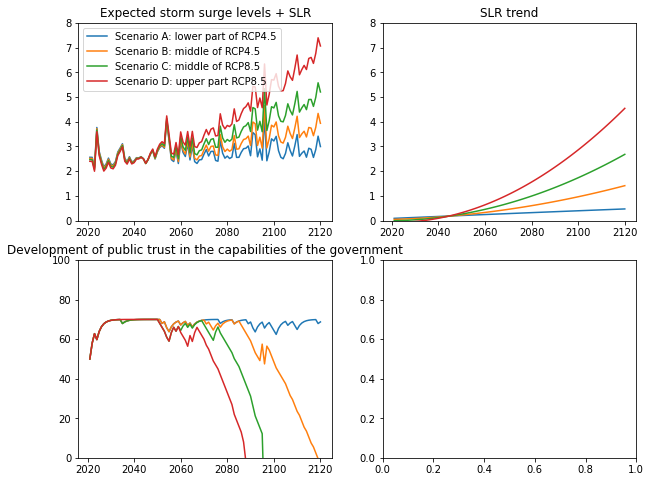

In [12]:
#Plot as a time series

fig, axes = plt.subplots(nrows=2,ncols=2,sharey=False,figsize=(10,8))
#fig = plt.figure()
axes[0,0].plot(time,levels_A_t,
             time,levels_B_t,
             time,levels_C_t,
             time,levels_D_t)
axes[0,0].legend(labels=[
    'Scenario A: lower part of RCP4.5',
    'Scenario B: middle of RCP4.5',   
    'Scenario C: middle of RCP8.5',   
    'Scenario D: upper part RCP8.5',
])
axes[0,0].set_title('Expected storm surge levels + SLR')
axes[0,1].set_title('SLR trend')
axes[1,0].set_title('Return period of storm surge levels')
axes[0,1].plot(time,A_t,time,B_t,time,C_t,time,D_t)

axes[0,0].set_ylim(0,8)
axes[0,1].set_ylim(0,8)


axes[1,0].plot(time,calculate_trust(time,levels_A_t),
               time,calculate_trust(time,levels_B_t),
               time,calculate_trust(time,levels_C_t),
               time,calculate_trust(time,levels_D_t))
axes[1,0].set_ylim(0,100)
axes[1,0].set_title('Development of public trust in the capabilities of the government')


# Initiate the classes (type of Lego blocks) of the model

In [6]:
#Initiate classes of the model (~make the type of lego Blocks)

#class IterRegistry(type): #Keep track of all the instances of the different classes that were created
#    def __iter__(cls):
#        return iter(cls._registry)

allFloodProtection = [] #List with all the flood protection objects relevant for the city
allResidentialArea = [] #List of all the residential areas in the city

class FloodProtection:
    """
    Initiate FloodProtection class, which are flood protection infrastructures which...
     - Protect a certain area
     - Against flood with a certain water level (in the baseline situation)
     - Moveable barrier?
    """
    
    def __init__(self,name,baseline_level,moveable):
        self.name = name #Name of the flood protection object (string)
        self.protection_level = baseline_level #initial level of flood protection
        self.barrier = moveable
        allFloodProtection.append(self) #Add to the overview of all flood protection objects
        
    def update_protection_level(self,increase):
        """Update a flood protection level object with some meters"""
        self.protection_level = self.protection_level + increase

class ResidentialArea():
    trust_0 = 70 #initial trust of citizens, same for all residential areas
    
    def __init__(self,name,elevation,protected_by):
        self.name = name #Name of the object (string)
        self.elevation = elevation #Elevation of the Residential Area in m
        self.protected_by = protected_by #Names of the FloodProtection objects it is protected by
        
        allResidentialArea.append(self) #Add to the overview of all flood protection objects
    
    def match_with_FloodProtection(self): #TODO Make sure that it does not add it two times!
        for i in allFloodProtection: #Iterate over all possible FloodProtections 
            for j in self.protected_by: #Iterate over the structures the area is protected by (for now only one! -> later expand and make decision rules if multiple exist)
                if i.name == j:
                    self.protection_level = i.protection_level
                    
    def __repr__(self): #this is wat you see if you say "object" (without printing)
        return self.name + " Elevation: " + str(self.elevation) + "\n Protected by: " + str(self.protected_by)
        
    def __str__(self): #this is what you see if you say "print(object)"
        return self.__dict__

class Major:
    def __init__(self,name):
        self.name = name

# Build the actual city

In [7]:
#Create Flood Protection objects
#Maeslantkering = FloodProtection("Maeslantkering",5,True)
Dike = FloodProtection("Sea Dike",4.5,False)
No = FloodProtection("No flood protection",4,False) # Assume 3 meter is the natural elevation of the Heijplaat

#Create ResidentialAreas
Area_A = ResidentialArea("Residential area A: the Heijplaat",4,["No flood protection"])
Area_B = ResidentialArea("Residential area B: city centre",1,["Sea Dike"])

#Create Major
Berry = Major("Berry Kroket")

##########

#ADD THE INFORMATION OF THE FLOOD PROTECTION STRUCTURES TO THE AREAS IT PROTECTS
for A in allResidentialArea:
    A.match_with_FloodProtection()
    print(A.__dict__)

{'name': 'Residential area A: the Heijplaat', 'elevation': 4, 'protected_by': ['No flood protection'], 'protection_level': 4}
{'name': 'Residential area B: city centre', 'elevation': 1, 'protected_by': ['Sea Dike'], 'protection_level': 4.5}


In [8]:
#Dike.update_protection_level(1)

In [9]:
def evaluate_event2(water_level_difference,alarming_conditions,report):
    """Returns a decrease in trust for a given difference between flood protection and observed storm surge level
    Inputs:
     *water_level_difference* (float) -- Flood protection level - storm surge level (so positive if flood occurs)
     *alarming_conditions* (OrderedDict) -- Dict containing the possible event thresholds
     *report* (boolean) -- Reports what the function is doing
    
    Return: a decrease in trust
    """ 
    for key, value in alarming_conditions.items():
        #print (key, value)
        if water_level_difference >= key:
            if report:
                print("This is a: {}, so trust goes down with {}".format(value[0],value[1]))
            break
    trust = value[1]
    return trust

#### Set parameters

In [10]:
alarming_conditions2 = OrderedDict({ #water depth respective to flood protection level, Name of event, reduction of trust if this happens.
    2   : ['Major flood',40], 
    1   : ['Small flood',20],
    0   : ['Near miss',5],
    -0.5  : ['Major wake-up',3],
    -1  : ['Minor wake-up',2],
    -10  : ['Nothing happens',0]
 })

measures = OrderedDict({ #key, name of measure,additional height, implementation time (years), million euro
    0 : ['Small dike heightening',1,5,10],
    1 : ['Large dike heighteing',3,10,50]
})

# Run the model over time

In [15]:
allSurgeSeries[0].name

'A'

In [21]:
Area_A.trust_t = OrderedDict()
Area_A.trust_t

OrderedDict()

In [26]:
for Area in allResidentialArea:
    Area.trust_t = OrderedDict() #TO TRACK THE DEVELOPMENT OF TRUST
    Area.trust_t[0] = Area.trust_0
    Area.event_impact_history = OrderedDict() #TO SAVE VALUES OF THE 'ALARMING CONDITIONS'
    Area.flood_history = OrderedDict() #TO SAVE FLOOD DEPTHS PER YEAR [IN M]
    for SurgeSeries in allSurgeSeries: #STORE THE RESULTS PER NAME OF THE STORM SURGE SERIES AS KEYS IN ORDERED DICT
        Area.trust_t[SurgeSeries.name] = [None] * len(time)
        Area.trust_t[SurgeSeries.name][0] = Area.trust_0
        Area.event_impact_history[event_impact_history.name] = [None] * len(time) #TO SAVE VALUES OF THE 'ALARMING CONDITIONS'
        Area.flood_history[event_impact_history.name] = [None] * len(time) #TO SAVE FLOOD DEPTHS PER YEAR [IN M]
        

In [42]:
#SELECT THE STORM SURGE SERIES FOR WHICH YOU WANT TO RUN

time = allSurgeSeries[0].years

for Area in allResidentialArea:
    Area.trust_t = OrderedDict() #TO TRACK THE DEVELOPMENT OF TRUST
    Area.trust_t[0] = Area.trust_0
    Area.event_impact_history = OrderedDict() #TO SAVE VALUES OF THE 'ALARMING CONDITIONS'
    Area.flood_history = OrderedDict() #TO SAVE FLOOD DEPTHS PER YEAR [IN M]
    for SurgeSeries in allSurgeSeries: #STORE THE RESULTS PER NAME OF THE STORM SURGE SERIES AS KEYS IN ORDERED DICT
        Area.trust_t[SurgeSeries.name] = [None] * len(time)
        Area.trust_t[SurgeSeries.name][0] = Area.trust_0
        Area.event_impact_history[SurgeSeries.name] = [None] * len(time) #TO SAVE VALUES OF THE 'ALARMING CONDITIONS'
        Area.flood_history[SurgeSeries.name] = [None] * len(time) #TO SAVE FLOOD DEPTHS PER YEAR [IN M]

for SurgeSeries in allSurgeSeries:
    # THE MODEL RUNS OVER A YEARLY TIMESTEP
    for i,t in enumerate(time): #Iterate over the years t, with index i
        #print(i,t)

        for Area in allResidentialArea:
            #FIRST EVALUATE IF THE FLOOD PROTECTION LEVEL IS EXCEEDED (TO DETERMINE IF FLOOD HAPPENS)
            if Area.protection_level < SurgeSeries.surgelevel[i]: #if a flood occurs
                Area.flood_history[SurgeSeries.name][i] = SurgeSeries.surgelevel[i] - Area.elevation
                #print("{} is inundated with a water depth of {} m \n --> damage occurs".format(Area.name,Area.flood_history[i]))

            #THEN EVALUATE THE IMPACT ON TRUST
            if i != 0: #don't evaluate trust in the first timestep!
                #print(Area.protection_level-levels_t[i])
                Area.event_impact_history[SurgeSeries.name][i] = evaluate_event2(SurgeSeries.surgelevel[i]-Area.protection_level,alarming_conditions2,False)
                #First evaluate the impact of this year's event (if any)
                if Area.event_impact_history[SurgeSeries.name][i] != 0:             #If something happens due to an event:
                    Area.trust_t[SurgeSeries.name][i] = Area.trust_t[SurgeSeries.name][i-1] - Area.event_impact_history[SurgeSeries.name][i]

                else:                             #If nothing happens the trust recovers exponentially
                    k = 0.4 
                    T_eq = 70
                    dTdt = (Area.trust_t[SurgeSeries.name][i-1]-T_eq)*-k
                    Area.trust_t[SurgeSeries.name][i] = Area.trust_t[SurgeSeries.name][i-1] + dTdt

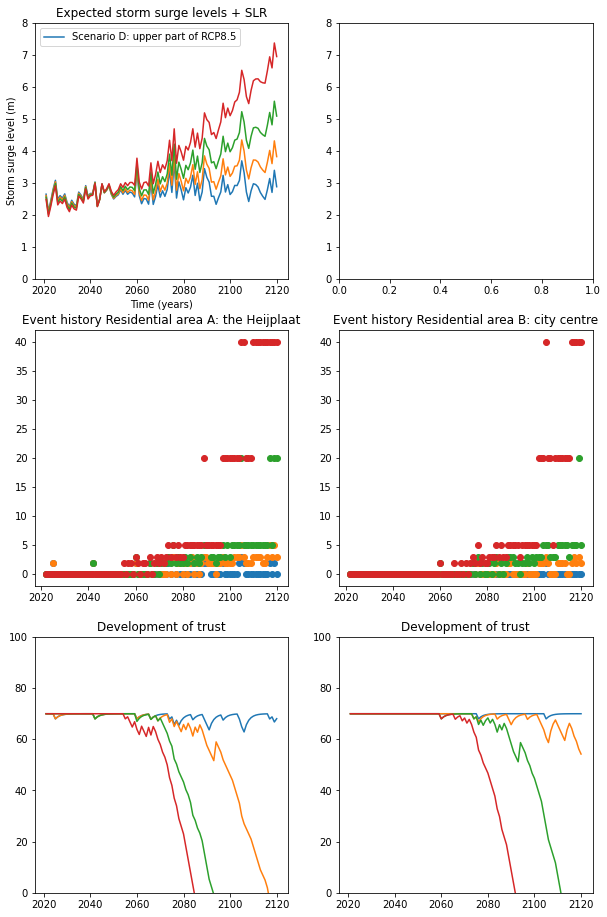

In [49]:
fig, axes = plt.subplots(nrows=3,ncols=2,sharey=False,figsize=(10,16))

for SurgeSeries in allSurgeSeries:
    axes[0,0].plot(SurgeSeries.years,SurgeSeries.surgelevel)

    axes[0,0].legend(labels=[SurgeSeries.description])
    axes[0,0].set_title('Expected storm surge levels + SLR')
    axes[0,0].set_xlabel('Time (years)')
    axes[0,0].set_ylabel('Storm surge level (m)')
    axes[0,0].set_ylim(0,8)
    axes[0,1].set_ylim(0,8)

    for i, Area in enumerate(allResidentialArea):
        axes[1,i].set_title('Event history {}'.format(allResidentialArea[i].name))
        axes[1,i].plot(SurgeSeries.years,allResidentialArea[i].event_impact_history[SurgeSeries.name],'o')

        axes[2,i].set_title('Development of trust')
        axes[2,i].plot(SurgeSeries.years,allResidentialArea[i].trust_t[SurgeSeries.name],)

        axes[2,i].set_ylim(0,100)


In [45]:
SurgeSeries.event_impact_history

[2021,
 2022,
 2023,
 2024,
 2025,
 2026,
 2027,
 2028,
 2029,
 2030,
 2031,
 2032,
 2033,
 2034,
 2035,
 2036,
 2037,
 2038,
 2039,
 2040,
 2041,
 2042,
 2043,
 2044,
 2045,
 2046,
 2047,
 2048,
 2049,
 2050,
 2051,
 2052,
 2053,
 2054,
 2055,
 2056,
 2057,
 2058,
 2059,
 2060,
 2061,
 2062,
 2063,
 2064,
 2065,
 2066,
 2067,
 2068,
 2069,
 2070,
 2071,
 2072,
 2073,
 2074,
 2075,
 2076,
 2077,
 2078,
 2079,
 2080,
 2081,
 2082,
 2083,
 2084,
 2085,
 2086,
 2087,
 2088,
 2089,
 2090,
 2091,
 2092,
 2093,
 2094,
 2095,
 2096,
 2097,
 2098,
 2099,
 2100,
 2101,
 2102,
 2103,
 2104,
 2105,
 2106,
 2107,
 2108,
 2109,
 2110,
 2111,
 2112,
 2113,
 2114,
 2115,
 2116,
 2117,
 2118,
 2119,
 2120]